# Daft Demo

## Here we show a demo of Daft of the following: 
- Initializing our cluster
- Daft Data Repos
- Use a Python Dataclass to define a Schema
- Load existing data from our Data Repos
- Write a function to download data from the web
- Write a function to decode and resize the image
- Write our own Schema for image storage
- Save downloaded images to the cloud
- Write our own embedding extractor for batch inference
- Save our embeddings to a data repo
- Preview our Schema

## Initializing our cluster

In [1]:
import daft

daft.init(ray_address="ray://localhost:10001")

## Daft Data Repos

In [2]:
from daft import datarepo

datarepo_client = datarepo.get_client()
datarepo_client.list_ids()

['openimages-dc-8000-v6']

## Defining our Own Schema
- ORM for binary data
- Translates to parquet under the hood
- Support for logical types like images, numpy arrays and any other types that you can define yourself

In [3]:
import dataclasses
from daft import dataclass

@dataclass
class OpenImagesMetadata:
    url: str
    size: int
    id: str

## Reading Data from our Data Repo

In [4]:
from daft.datarepo.datarepo import DataRepo, DaftLakeLog

datarepo = DataRepo(DaftLakeLog("s3://eventual-data-test-bucket/datarepos/openimages-dc-8000-v6"))
query = datarepo.query(OpenImagesMetadata)

/home/jay/code/DaFt/daft/datarepo/log.py:131: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  self._load_state()


## Previewing our Data

In [5]:
ds = query.limit(5).execute()
print(ds)
ds.show(4)

(_prepare_read pid=7381) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:279: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7381)   metadata = meta_provider.prefetch_file_metadata(pq_ds.pieces) or []
(_prepare_read pid=7381) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:283: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7381)   np.array_split(pq_ds.pieces, parallelism),
Map Progress: 100%|██████████████████████████████████████████████████████████

Dataset(num_blocks=1, num_rows=5, schema=<class '__main__.OpenImagesMetadata'>)
OpenImagesMetadata(url='https://farm2.staticflickr.com/2175/2430631798_741f14a155_o.jpg', size=3542868, id='zaH5VPO6mUz+slkBgW/LjQ==')
OpenImagesMetadata(url='https://c5.staticflickr.com/2/1281/591873401_74fdccef23_o.jpg', size=203678, id='bc0yEwO5kt329OlPI3kSmg==')
OpenImagesMetadata(url='https://c3.staticflickr.com/4/3731/13656227485_3423bf08d8_o.jpg', size=151590, id='aL0NsCYdxMDECzVKRnabNg==')
OpenImagesMetadata(url='https://farm2.staticflickr.com/4042/4322105010_d71bce0033_o.jpg', size=1180544, id='yhy22Obl8rqx2cIhi+JjJg==')


In [11]:
import concurrent.futures
import requests
from typing import List

from daft.datarepo.query import functions as F

def download_single(url: str) -> bytes:
    r = requests.get(url)
    if r.status_code == 200:
        return r.content
    else:
        return b''

@F.batch_func(batch_size=64)
def download_batch(batch: List[str]) -> List[bytes]:
    with concurrent.futures.ThreadPoolExecutor() as exector : 
        futures = exector.map(download_single, batch)
        return list(futures)


### Download via a batched map

In [12]:
%%time

with_downloaded_column = query.with_column("payload", download_batch("url"))

CPU times: user 187 µs, sys: 16 µs, total: 203 µs
Wall time: 195 µs


In [13]:
# TODO(jay): This print should print all the columns in the current query builder
with_downloaded_column

## Decode and Resize our downloaded images

In [14]:
import PIL.Image
import io

@F.func
def resized_pil_image(payload: bytes, size:int=256) -> PIL.Image:
    """Loads a payload of bytes as a PIL image and resizes it to specified given size"""
    with io.BytesIO(payload) as f:
        try:
            img = PIL.Image.open(f)
            img = img.resize((size,size))
            img = img.convert("RGB")
        except Exception as e:
            img = PIL.Image.new("RGB", (size, size))
        return img

In [15]:
with_pil_column = with_downloaded_column.with_column("img", resized_pil_image("payload"))

In [16]:
# TODO(jay): This print should print all the columns in the current query builder
with_pil_column

### Lets look at our images

(_prepare_read pid=7452) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:279: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7452)   metadata = meta_provider.prefetch_file_metadata(pq_ds.pieces) or []
(_prepare_read pid=7452) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:283: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7452)   np.array_split(pq_ds.pieces, parallelism),
Map Progress: 100%|██████████████████████████████████████████████████████████

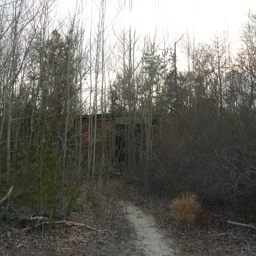

In [17]:
ds = with_pil_column.limit(5).execute()
items = ds.take(5)
items[0].img

### Defining our function for Batch Inference

In [19]:
from typing import Tuple

import numpy as np
import torch
import torchvision


@F.batch_func(batch_size=8)
class BatchInferModel:
    def __init__(self):
        """
        Here we init our model as well as needed data transforms
        """
        self.model_name = "resnet18"
        model = torchvision.models.resnet18(pretrained=True).eval()
        self.feature_extractor = torchvision.models.feature_extraction.create_feature_extractor(
            model=model, 
            return_nodes={'avgpool': 'embedding'}
        )
        self.to_tensor = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )]
        )
    
    def prepare_batch(self, image_data: List[PIL.Image.Image]) -> torch.Tensor:
        """
        Here we convert our PIL image to a normalized tensor
        """
        return torch.stack([self.to_tensor(img) for img in image_data])
    
    def __call__(self, image_data: List[PIL.Image.Image]) -> List[np.ndarray]:
        """
        Here we extract our embedding with resnet 18
        """
        with torch.no_grad():
            tensor = self.prepare_batch(image_data)
            embedding =  self.feature_extractor(tensor.float())['embedding'].view(len(image_data), -1)
            np_embedding = embedding.cpu().numpy()
            dim = np_embedding.shape[1]
            per_image_embedding = np.vsplit(np_embedding, np.arange(1, len(image_data)))
            return per_image_embedding

## Running large scale batch inference

In [20]:
%%time

with_embeddings = with_pil_column \
    .with_column("embedding", BatchInferModel("img")) \
    .with_column("mean", F.func(lambda e: e.mean(), return_type=float)("embedding")) \
    .with_column("std", F.func(lambda e: e.std(), return_type=float)("embedding")) \
    .with_column("dim", F.func(lambda e: e.shape[1], return_type=int)("embedding"))

CPU times: user 719 µs, sys: 72 µs, total: 791 µs
Wall time: 661 µs


In [21]:
# TODO(jay): Print the schema up to this point
with_embeddings

In [22]:
%%time

ds = with_embeddings.execute()

(_prepare_read pid=7381) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:279: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7381)   metadata = meta_provider.prefetch_file_metadata(pq_ds.pieces) or []
(_prepare_read pid=7381) /tmp/ray/session_2022-06-08_14-10-28_326715_1/runtime_resources/py_modules_files/s3_eventual-release-artifacts-bucket_daft_package-amd64_latest/ray/data/datasource/parquet_datasource.py:283: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_prepare_read pid=7381)   np.array_split(pq_ds.pieces, parallelism),
Map Progress: 100%|██████████████████████████████████████████████████████████

CPU times: user 7.04 s, sys: 1.11 s, total: 8.14 s
Wall time: 2min 37s


## Save our extracted embeddings to the cloud in Parquet

In [ ]:
datarepo_client.save('open-images-8k-processed-embeddings', embeddings)

## Peeking under the Hood of Serialization

In [ ]:
print(ProcessedEmbedding._daft_schema.arrow_schema())